# Information Security - Term Project Implementation Code

## Setting

In [1]:
%pip install librosa
%pip install pi-heaan
%pip install numpy
%pip install pandas
%pip install Flask librosa
%pip install matplotlib
import numpy as np
import librosa
import matplotlib.pyplot as plt
import piheaan as heaan
from piheaan.math import sort
from piheaan.math import approx # for piheaan math function
from werkzeug.utils import secure_filename
import math
import pandas as pd
import os
import time

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# set parameter
params = heaan.ParameterPreset.FGb
context = heaan.make_context(params) # context has paramter information
heaan.make_bootstrappable(context) # make parameter bootstrapable

# create and save keys
key_file_path = "./keys"
sk = heaan.SecretKey(context) # create secret key
os.makedirs(key_file_path, mode=0o775, exist_ok=True)
sk.save(key_file_path+"/secretkey.bin") # save secret key

key_generator = heaan.KeyGenerator(context, sk) # create public key
key_generator.gen_common_keys()
key_generator.save(key_file_path+"/") # save public key

# load secret key and public key
# When a key is created, it can be used again to save a new key without creating a new one
key_file_path = "./keys"

sk = heaan.SecretKey(context,key_file_path+"/secretkey.bin") # load secret key
pk = heaan.KeyPack(context, key_file_path+"/") # load public key
pk.load_enc_key()
pk.load_mult_key()

eval = heaan.HomEvaluator(context,pk) # to load piheaan basic function
dec = heaan.Decryptor(context) # for decrypt
enc = heaan.Encryptor(context) # for encrypt

## Zero-Padding Function

In [3]:
# For the FFT function to work, 
# the length of the signal array must be a square number of 2. 
# Therefore, a function that zero-padding 
# such that the length of the array becomes a square of 2
def pad_to_power_of_two(signal):
    length = len(signal)

    exponent_number = int(np.ceil(np.log2(length)))
    next_power_of_two = 2 ** exponent_number
    
    if length != next_power_of_two:
        num_zeros = next_power_of_two - length
        padded_signal = np.pad(signal, (0, num_zeros), mode='constant')
    else:
        padded_signal = signal

    # return zero-padded signal array and its exponent number
    # this exponent number would be a log_slots for heaan
    return padded_signal

# Function for find proper slot size 
# to process user's input signal file
def find_slot_size(signal):
    if type(signal) == int:
        exponent_number = int(np.ceil(np.log2(signal)))
        return exponent_number
    else :
        length = len(signal)
        exponent_number = int(np.ceil(np.log2(length)))
        return exponent_number

## FFT with Encrypted Signal

In [4]:
# Self written, default Fast-Fourier-Transform function
def fft(signal):
    N = len(signal)
    if N <= 1:
        return signal
    else:
        even_fft = fft(signal[0::2])
        odd_fft = fft(signal[1::2]) 
        T_1 = -2j * np.pi 
        T_2 = len(odd_fft)
        T_3 = np.arange(T_2)
        T_4 = T_1 * T_3
        T_5 = T_4 / N
        T_6 = np.exp(T_5)
        T_7 = T_6 * odd_fft

        return_value = np.concatenate([even_fft + T_7, even_fft - T_7])
        
        return return_value

# Self written, first modified Fast-Fourier-Transform function
def fft_at_user_side_first_modification(signal):
    N = len(signal)
    if N <= 1:
        return signal
    else:
        # Slicing the even elements
        even_signal = signal[0::2]
        # path them to the same function in nested-manner
        even_fft = fft_at_user_side(even_signal)
        # calculate needed slot numbers and encrypt them
        even_log_slots = find_slot_size(even_fft)
        even_num_slots = 2 ** even_log_slots
        even_plain_signal = heaan.Message(even_log_slots)
        for i in range(even_num_slots):
            even_plain_signal[i] = even_fft[i]
        even_cipher_signal = heaan.Ciphertext(context)
        enc.encrypt(even_plain_signal, pk, even_cipher_signal)

        # Slicing the odd elements
        odd_signal = signal[1::2]
        # path them to the same function in nested-manner
        odd_fft = fft_at_user_side_first_modification(odd_signal) 
        # calculate needed slot numbers and encrypt them
        odd_log_slots = fft_at_user_side_first_modification(odd_fft)
        odd_num_slots = 2 ** odd_log_slots
        odd_plain_signal = heaan.Message(odd_log_slots)
        for i in range(odd_num_slots):
            odd_plain_signal[i] = odd_fft[i]
        odd_cipher_signal = heaan.Ciphertext(context)
        enc.encrypt(odd_plain_signal, pk, odd_cipher_signal)

        # Set aside the operation parts(T_1 to T_7 in default function) to the server side functions
        # So the server only receive the encrypted signal data after slicing them
        value_1, value_2 = fft_at_server_side(even_cipher_signal, odd_cipher_signal)

        # Recieve the FFT processed data from server, and decrypt them
        dec_value_1 = heaan.Message(odd_log_slots)
        dec.decrypt(value_1, sk, dec_value_1)
        dec_value_2 = heaan.Message(odd_log_slots)
        dec.decrypt(value_2, sk, dec_value_2)
        return_value = list(dec_value_1) + list(dec_value_2)

        return return_value

# Self written, second modified Fast-Fourier-Transform function
def fft_at_user_side_second_modification(signal):
    N = len(signal)
    if N <= 1:
        return signal
    else:
        # Additional parts from first modification
        # 1024 could be varied
        # If the length is smaller than that value, 
        # its FFT operation is conducted in User's local environment
        if N <= 1024:
            even_fft = fft(signal[0::2])
            odd_fft = fft(signal[1::2]) 
            T_1 = -2j * np.pi
            T_2 = len(odd_fft)
            T_3 = np.arange(T_2)
            T_4 = T_1 * T_3
            T_5 = T_4 / N
            T_6 = np.exp(T_5)
            T_7 = T_6 * odd_fft
    
            return_value = np.concatenate([even_fft + T_7, even_fft - T_7])
        
            return return_value
        else:
            even_signal = signal[0::2]
            even_fft = fft_at_user_side_second_modification(even_signal)
            even_log_slots = find_slot_size(even_fft)
            even_num_slots = 2 ** even_log_slots
            even_plain_signal = heaan.Message(even_log_slots)
            for i in range(even_num_slots):
                even_plain_signal[i] = even_fft[i]
            even_cipher_signal = heaan.Ciphertext(context)
            enc.encrypt(even_plain_signal, pk, even_cipher_signal)
    
            odd_signal = signal[1::2]
            odd_fft = fft_at_user_side_second_modification(odd_signal) 
            odd_log_slots = find_slot_size(odd_fft)
            odd_num_slots = 2 ** odd_log_slots
            odd_plain_signal = heaan.Message(odd_log_slots)
            for i in range(odd_num_slots):
                odd_plain_signal[i] = odd_fft[i]
            odd_cipher_signal = heaan.Ciphertext(context)
            enc.encrypt(odd_plain_signal, pk, odd_cipher_signal)
            
            value_1, value_2 = fft_at_server_side(even_cipher_signal, odd_cipher_signal)
            dec_value_1 = heaan.Message(odd_log_slots)
            dec.decrypt(value_1, sk, dec_value_1)
            dec_value_2 = heaan.Message(odd_log_slots)
            dec.decrypt(value_2, sk, dec_value_2)
            return_value = list(dec_value_1) + list(dec_value_2)
    
            return return_value

def fft_at_server_side(even_cipher_signal, odd_cipher_signal):
        T_1 = -2j * np.pi # constant  
        T_2 = len(odd_cipher_signal) # variable, but not significant
        N = T_2 * 2
        T_3 = np.arange(T_2) # variable, but not significant(derived from T_2)
        T_4 = T_1 * T_3 # variable, but not significant(derived from T_2)
        T_5 = T_4 / N # variable, but not significant(derived from T_2)
        T_6 = np.exp(T_5) # variable, but not significant(derived from T_2)
    
        adjusted_T_2 = find_slot_size(T_2)
        
        T_6_message = heaan.Message(adjusted_T_2)
        for i in range(2 ** adjusted_T_2):
            T_6_message[i] = T_6[i]

        result_mult = heaan.Ciphertext(context)
        eval.mult(odd_cipher_signal, T_6_message, result_mult)
        result_add = heaan.Ciphertext(context)
        eval.add(even_cipher_signal, result_mult, result_add)

        result_sub = heaan.Ciphertext(context)
        eval.sub(even_cipher_signal, result_mult, result_sub)

        return [result_add, result_sub] # significant!!, HE operation is needed

## Flask Web Application Implementation

In [5]:
from flask import Flask, request, jsonify, render_template, send_from_directory
import threading
import os
import librosa
from werkzeug.utils import secure_filename
import json

# set the path for base directory 
# please change the directory path to the path where the project folder is located in your environment
base_dir = os.path.abspath(os.path.dirname('C:/Users/user/Downloads/pi-heaan/')) 
template_path = os.path.join(base_dir, 'templates') # set the path from which the .html template will be loaded
app = Flask(__name__, template_folder=template_path) # Initiate the Flask with the template path

# Define the function which will be executed when the initial web page is opened
@app.route('/') 
def index():
    return render_template('index.html')

# Define the function which will be conducted when the user click the 'Upload' button on the web site
@app.route('/upload', methods=['POST'])
def upload():
    file = request.files['file'] # Get the input file from the user and save it to the 'file' variable
    if file and allowed_file(file.filename): # Check whether the file extension is '.mp3' or not
        file_path = os.path.join(base_dir, 'uploads', secure_filename(file.filename)) # set the folder path where the user input file will be saved
        file.save(file_path) # save the user input file to the 'uploads' folder in base_dir

        origin_signal, sr = librosa.load(file_path, sr=8000) # load the .mp3 file
        if len(origin_signal) == 0: # check whether the length of loaded file is 0 or not
            return jsonify(message="Loaded audio file is empty or invalid."), 400 # error handling
        
        origin_signal = list(origin_signal) # make the list for orignal signal in order to conduct a zero-padding operation with respect to it
        signal = pad_to_power_of_two(origin_signal) # zero-padded ndarray is returned and saved to the signal variable
        return jsonify(signal=signal.tolist()) # the type of signal is ndarray and it is not serializable, so it is converted into the list for jsonifying
    else:
        return jsonify(message="No file found"), 400 # error handling

# Define the function which will be used when user click the 'Proceed FFT' button after zero-padding operation for input file
@app.route('/process_fft', methods=['POST'])
def process_fft():
    try:
        data = request.get_json() # Get the jsonified zero-padded signal
        if 'signal' not in data: # error handling
            return jsonify(message="No signal data found in request"), 400

        signal = np.array(data['signal']) # Turn the received jsonified signal into original zero-padded signal
        
        result_no_HE = fft(signal[::]) # conduct fft without HE using custom fft function
        result_HE = fft_at_user_side_second_modification(signal[::]) # conduct fft with HE using custom fft function
        
        # Drawing Plots
        fft_results = [np.fft.fft(signal), np.array(result_no_HE[::]), np.array(result_HE[::])] # 
        titles = ['Numpy based Frequency Domain Signal (Numpy FFT)', 
                  'Custom Frequency Domain Signal (Custom FFT) without HE', 'Custom Frequency Domain Signal (Custom FFT) with HE']
        sampling_rate = 8000  # Sampling Rate (Hz)

        plt.figure(figsize=(15, 10))  # Configure the size of whole graph

        for i, fft_result in enumerate(fft_results):
            L = len(fft_result)  # Legnth of the FFT result
            frequencies = np.fft.fftfreq(L, 1.0 / sampling_rate)
            frequencies = frequencies[:L // 2]  # only the positive frequency vectors will be used
            
            fft_magnitude = np.abs(fft_result / L)
            fft_magnitude = fft_magnitude[:L // 2] * 2  # only the positive frequency vectors will be used
            
            plt.subplot(3, 1, i + 1)  # Place 3 graphs vertically
            plt.plot(frequencies, fft_magnitude)
            plt.title(titles[i])
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Magnitude')
            plt.grid(True)
            plt.tight_layout()

        plot_path = os.path.join(base_dir, 'fft_plots.png')
        plt.savefig(plot_path)
        plt.close()

        result_path = os.path.join(base_dir, 'fft_result.txt')
        np.savetxt(result_path, np.abs(fft_result), delimiter=',')
        
        return jsonify(url='/download/fft_result.txt', plot_url='/download/fft_plots.png')
    except Exception as e:
        return jsonify(message=f"Error during FFT processing: {str(e)}"), 500 # error handling

# the function which will be used when the user click the 'Download FFT Result'
# user can download the result of fft operation with Homomorphic Encryption thanks to this function
@app.route('/download/<filename>')
def download_file(filename):
    return send_from_directory(directory=base_dir, path=filename, as_attachment=True)

# the function which check whether the file extention of user input file is .mp3 or not
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in {'mp3'}

# the function to run the flask app
def run_app():
    app.run(port=5000, debug=True, use_reloader=False)

threading.Thread(target=run_app).start()




 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


## Performance and Visualization

In [6]:
# load the mp3 file(signal file)
file_path = os.path.join(base_dir, 'hey_siri.mp3')
origin_signal, sr = librosa.load(file_path, sr=8000)
origin_signal = list(origin_signal)
# pad the original signal for FFT function, and calculate needed size of the slot
signal  = pad_to_power_of_two(origin_signal)
print(len(signal))


32768


In [7]:
# check the processing time for custom FFT function without HE
start_time = time.time()
result_no_HE = fft(signal[::])
end_time = time.time()
elapsed_time_1 = end_time - start_time
print(f"No_HE Elapsed time: {elapsed_time_1} seconds")

# check the processing time for custom FFT function with HE
start_time = time.time()
result_HE = fft_at_user_side_second_modification(signal[::])
end_time = time.time()
elapsed_time_2 = end_time - start_time
print(f"HE Elapsed time: {elapsed_time_2} seconds")

# check the performace gap ratio
print(f"Performance gap: {elapsed_time_2/elapsed_time_1} times slower")

No_HE Elapsed time: 0.35696887969970703 seconds
HE Elapsed time: 0.5771589279174805 seconds
Performance gap: 1.6168326169020781 times slower


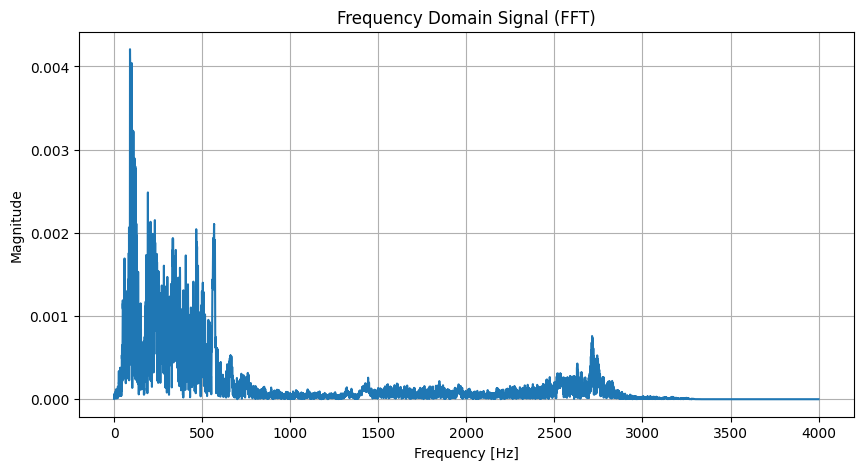

In [8]:
# Plot for Numpy based FFT without HE
fft_result = np.fft.fft(signal)

# Sampling rate (Hz)
sampling_rate = 8000 

# Legnth of the FFT result
L = len(fft_result)

# Creating frequency vectors
frequencies = np.fft.fftfreq(L, 1.0 / sampling_rate)
frequencies = frequencies[:L // 2]  # only the positive frequency vectors will be used

# Calculate the size of FFT
fft_magnitude = np.abs(fft_result / L)
fft_magnitude = fft_magnitude[:L // 2] * 2 # only the positive frequency vectors will be used

# Draw the graph
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fft_magnitude)
plt.title('Frequency Domain Signal (FFT)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

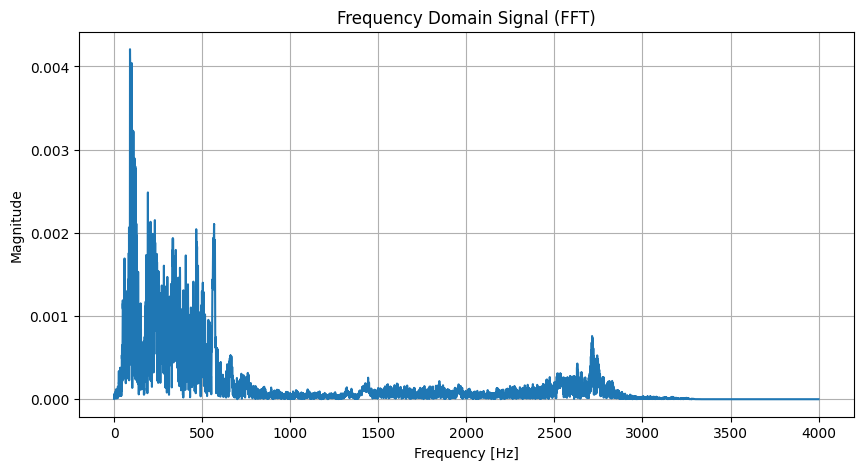

In [9]:
# Plot for Custom FFT without HE

fft_result = np.array(result_no_HE[::])  # 여기에 FFT 결과 배열을 넣으세요
sampling_rate = 8000  # 샘플링 레이트 (Hz)

# Sampling rate (Hz)
sampling_rate = 8000 

# Legnth of the FFT result
L = len(fft_result)

# Creating frequency vectors
frequencies = np.fft.fftfreq(L, 1.0 / sampling_rate)
frequencies = frequencies[:L // 2]  # only the positive frequency vectors will be used

# Calculate the size of FFT
fft_magnitude = np.abs(fft_result / L)
fft_magnitude = fft_magnitude[:L // 2] * 2 # only the positive frequency vectors will be used

# Draw the graph
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fft_magnitude)
plt.title('Frequency Domain Signal (FFT)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

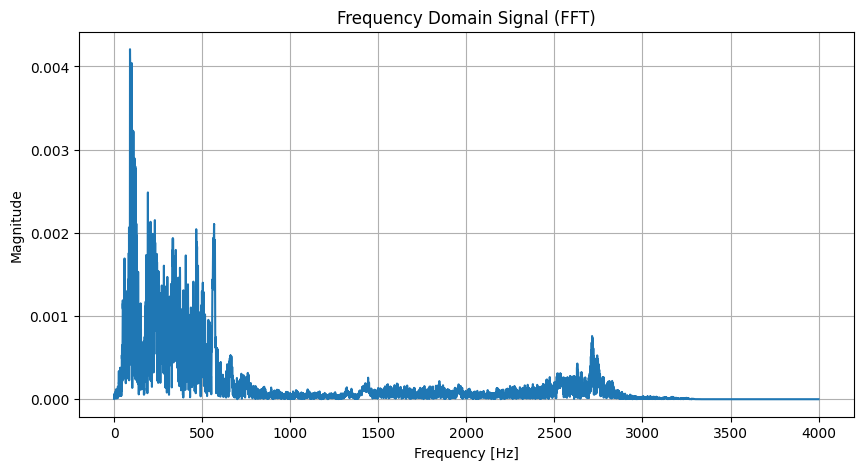

In [10]:
# Plot for Custom FFT with HE
fft_result = np.array(result_HE[::])  # 여기에 FFT 결과 배열을 넣으세요

# Sampling rate (Hz)
sampling_rate = 8000 

# Legnth of the FFT result
L = len(fft_result)

# Creating frequency vectors
frequencies = np.fft.fftfreq(L, 1.0 / sampling_rate)
frequencies = frequencies[:L // 2]  # only the positive frequency vectors will be used

# Calculate the size of FFT
fft_magnitude = np.abs(fft_result / L)
fft_magnitude = fft_magnitude[:L // 2] * 2 # only the positive frequency vectors will be used

# Draw the graph
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fft_magnitude)
plt.title('Frequency Domain Signal (FFT)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.show()